# Introduction to PipeSystems

Minipipe has two API's, PipeLine and PipeSystem. PipeLine is a simple sequential API for linear pipelines. However, it's also possible to build more complex pipe systems with Minipipe that may branch and join to form more complex graph topologies. In this section we'll introduce the concepts of multiple inputs/outputs, switchs and regulators.  

In [1]:
from minipipe import Source, Transform, Sink, Regulator
import numpy as np

@Source
def genRand(n=5):
    for _ in range(n):
        yield np.random.rand(4)

@Regulator
def batch(batch_size=2):
    # A coroutine for breaking data up into batches of 2
    x = (yield)
    for i in range(len(x)//batch_size):
        yield x[i*batch_size:(i+1)*batch_size]

@Transform 
def sumBatch(x):
    # simple tranform on data
    return x.sum()

@Transform 
def switch(x):
    # if-then switch 
    return [x, None] if x > 1 else [None, x]

@Sink
def output_gt_1(x):
    # sink for greater than 1
    print('1 <',x)

@Sink
def output_lt_1(x):
    # sink for less than 1
    print('1 >',x)

First we've introduced a Python coroutine `batch`. This coroutine breaks up the data into batches of size 2. This is an example of a Regulator functor. 

We've also introduced the concept of a switch functor. This functor has two outputs, in this case a list with two elements, however we could have just as easily used a standard tuple. When a Python `None` is encountered in a pipe segment it is simple ignored. Thus `switch` returns x in either the first or second output depending on the value of x. 

The PipeSystem API allows you to define general graphs that may branch and join however you choose. In the PipeSystem API you explicitly define the nodes (Pipes) and edges (Streams) of your graph. 

In [2]:
from minipipe import Stream 

strm = [Stream() for _ in range(5)]

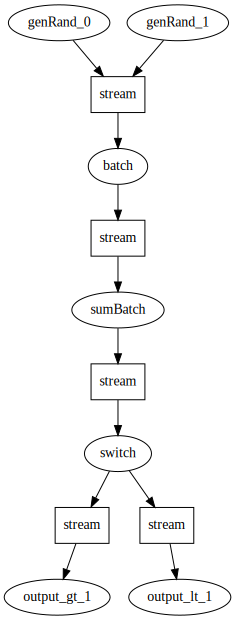

In [5]:
from minipipe import PipeSystem

g1 = genRand()
g2 = genRand()

psys = (PipeSystem()
        .add(g1, downstreams=strm[0])
        .add(g2, None, strm[0])
        .add(batch, upstreams=strm[0], downstreams=[strm[1]])
        .add(sumBatch, strm[1], strm[2])
        .add(switch, strm[2], strm[3:])
        .add(output_gt_1, strm[3])
        .add(output_lt_1, strm[4])
        .build())

psys.diagram(True)

Since `switch` has two outputs it must have two downstreams, otherwise the list/tuple will be interpreted as a single output. Pipe segments may also have multiple inputs, in which case they must have multiple upstreams. 

In [4]:
# Run pipesystem
psys.run()

1 > 0.5637425404417911
1 < 1.0086590836312175
1 < 1.063084369373772
1 < 1.4601343311471102
1 > 0.5637425404417911
1 < 1.0086590836312175
1 < 1.2447160060215496
1 < 1.4960315799951167
1 < 1.063084369373772


2020-02-06 21:35:13,333 - INFO - genRand_0 - End of stream


1 < 1.4601343311471102
1 > 0.6342910064321654
1 < 1.0346158192802946
1 < 1.2447160060215496


2020-02-06 21:35:13,340 - INFO - genRand_0 - Local termination


1 > 0.8731939869032546
1 < 1.4960315799951167
1 < 1.0414750052943968
1 < 1.0346158192802946
1 > 0.6342910064321654
1 < 1.0414750052943968
1 > 0.8731939869032546


2020-02-06 21:35:13,338 - INFO - genRand_1 - End of stream
2020-02-06 21:35:13,358 - INFO - genRand_1 - Local termination
2020-02-06 21:35:13,359 - INFO - batch - Local termination
2020-02-06 21:35:13,390 - INFO - sumBatch - Local termination
2020-02-06 21:35:13,422 - INFO - output_lt_1 - Local termination
2020-02-06 21:35:13,422 - INFO - output_gt_1 - Local termination
2020-02-06 21:35:13,422 - INFO - switch - Local termination
